In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [161]:
find_search_prob = 0.5 
find_wait_prob =  0.2
penality = -3
canReward = 1
rechargeReward = 0
alpha = 0.6
beta = 0.8
numStates = 2
numActions = 3
notFoundReward = 0

In [162]:
class recyclingRobot:
    def __init__(self):
        self.actions = {
            "high":["search","wait"],
            "low":["search","wait","recharge"]
        }
        self.states = ["high","low"]
        self.state = self.states[0]
        self.next_action_probability = np.array([
        [0.34, 0.50],
        [0.33, 0.50],
        [0.33, 0.00]]) # p(a|s)
        self.next_state_probability = {
                "search":{
                    "high":alpha,
                    "low":1-beta},
                "wait":{
                    "high":1,
                    "low":0},
                "recharge":{
                    "high":None,
                    "low":1}
        } # p(s'= high |s,a)
        self.expected_rewards_table = {
            "high":{
                "search":{},
                "wait":{},
            },
            "low":{
                "search":{},
                "wait":{},
                "recharge":{},
            },
        } # r(s,a,s')
        self.alpha = 0.1 # step size
        self.gamma = 0.9 # discount factor
        self.epsilon = 0.1 # greedy-probability
        self.rewards = {
            "high":{
                "search":[canReward,notFoundReward],
                "wait":[canReward,notFoundReward],
            },
            "low":{
                "search":[penality,canReward,notFoundReward],
                "wait":[canReward,notFoundReward],
                "recharge":[rechargeReward]
            }
        } #r(s,a)
        self.probabilities = {
           "high":{
                "search":[find_search_prob,1-find_search_prob],
                "wait":[find_wait_prob,1-find_wait_prob],
            },
            "low":{
                "search":[1-beta,beta*find_search_prob,beta*(1-find_search_prob)],
                "wait":[find_wait_prob,1-find_wait_prob],
                "recharge":[1]
            } 
        } #p(r|s,a)
        self.calculate_expected_rewards_table()
        self.stateValues = {
            "high":0,
            "low":0
        } #v(s)

        self.actionValues ={
            "high":{
                "search":0,
                "wait":0,
            },
            "low":{
                "search":0,
                "wait":0,
                "recharge":0
            }
        } #q(s,a)

        self.enviromentDynamics = {
            "high":{
                "search":{
                    "high":{canReward:find_search_prob},
                    "low":{canReward:find_search_prob},
                },
                "wait":{
                    "high":{canReward:find_wait_prob},
                    "low":{},
                }
            },
            "low":{
                "search":{
                    "high":{penality:1-beta},
                    "low":{canReward:beta*find_search_prob},
                },
                "wait":{
                    "high":{},
                    "low":{canReward:find_wait_prob},
                },
                'recharge':{
                    "low":{},
                }
            }
        } #p(r,s'|s,a)



    def calculate_expected_rewards_table(self):
        for state in self.states:
            for action in self.actions[state]:
                for nextState in self.states:
                    nextStateProbabily = self.next_state_probability[action][state] if nextState == "high" else (1-self.next_state_probability[action][state])
                    num = sum([self.rewards[state][action][i]*nextStateProbabily*self.probabilities[state][action][i] for i in range(len(self.probabilities[state][action]))])
                    self.expected_rewards_table[state][action][nextState] = num/nextStateProbabily if nextStateProbabily != 0 else 0


    def search(self,successProbability):
        if self.state == "high":
            if np.random.rand() < alpha:
                self.state = "low"
        else:
            if np.random.rand() < beta:
                self.state = "high"
                return penality
        
        if np.random.rand() < successProbability:
             return canReward
        else:
             return 0

    def wait(self,successProbability):
         if np.random.rand() < successProbability:
             return canReward
         else:
             return 0

    def recharge(self):
        self.state = "high"
        return rechargeReward

    def updateActions(self):
        if self.state == "high":
            self.actions = [self.search,self.wait]
        else:
            self.actions = [self.search,self.wait,self.recharge]
    
    def updateStateValues(self):
        rs = canReward*find_search_prob
        rw = canReward*find_wait_prob
        self.stateValues["high"] = max([
            rs+self.gamma*(alpha*self.stateValues["low"]+(1-alpha)*self.stateValues["high"]),
            rw + self.gamma*self.stateValues["high"]
            ])
        self.stateValues["low"] = max([
            beta*rs-3*(1-beta)+self.gamma*((1-beta)*self.stateValues["high"]+beta*self.stateValues["low"]),
            rw + self.gamma*self.stateValues["low"],
            self.gamma*self.stateValues["high"]
            ])
        

    def updateActionValues(self):
            for state in self.states:
                for action in self.actions[state]:
                    temp = 0
                    for nextState in self.enviromentDynamics[state][action]:
                        for reward in self.enviromentDynamics[state][action][nextState]:
                            temp += self.enviromentDynamics[state][action][nextState][reward]*(reward+self.gamma*max([self.actionValues[nextState][a] for a in self.actions[nextState]]))
                    self.actionValues[state][action] = temp

In [163]:
robot = recyclingRobot()

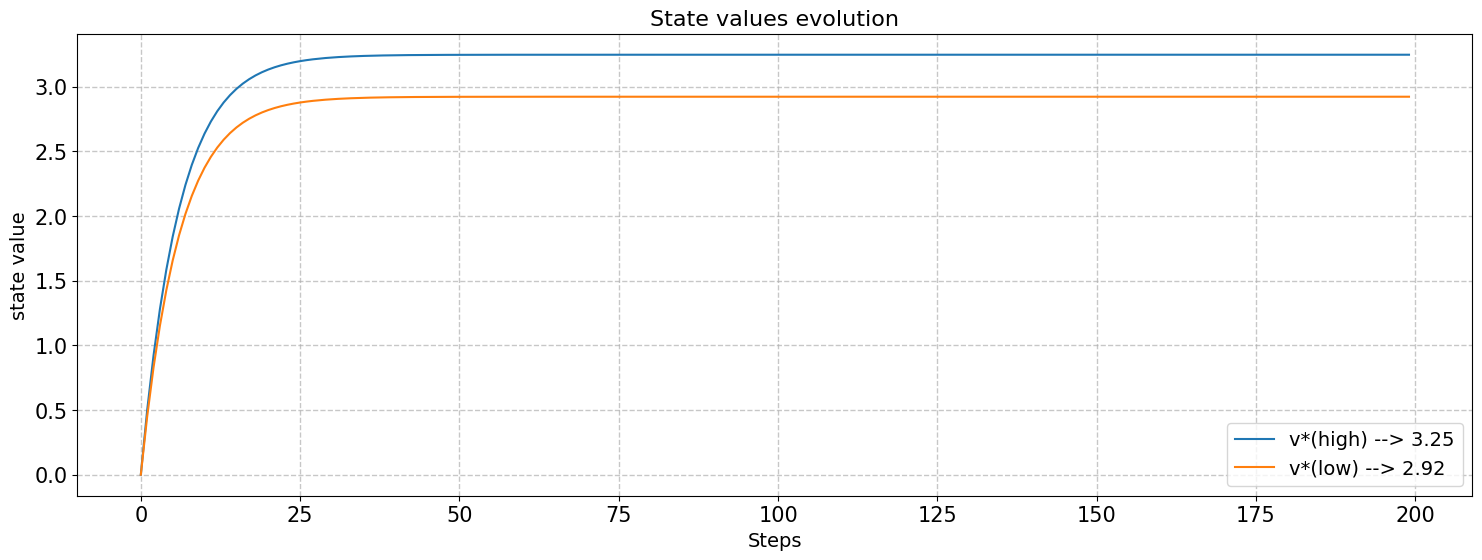

In [164]:
steps = 200
highStateValueVector = np.zeros(steps)
lowStateValueVector = np.zeros(steps)
for i in range(steps):
    highStateValueVector[i] = robot.stateValues["high"]
    lowStateValueVector[i] = robot.stateValues["low"]
    robot.updateStateValues()

fig, ax = plt.subplots(figsize=(18,6))
plt.plot(range(steps),highStateValueVector,label=f"v*(high) --> {highStateValueVector[i]:.2f}")
plt.plot(range(steps),lowStateValueVector,label=f"v*(low) --> {lowStateValueVector[i]:.2f}")
ax.set_title('State values evolution', fontsize=16)
plt.legend(fontsize = 14)
ax.set_ylabel('state value', fontsize=14)
ax.set_xlabel('Steps', fontsize=14)
ax.grid(True, which='both', linestyle='--', linewidth=1, alpha=0.7)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

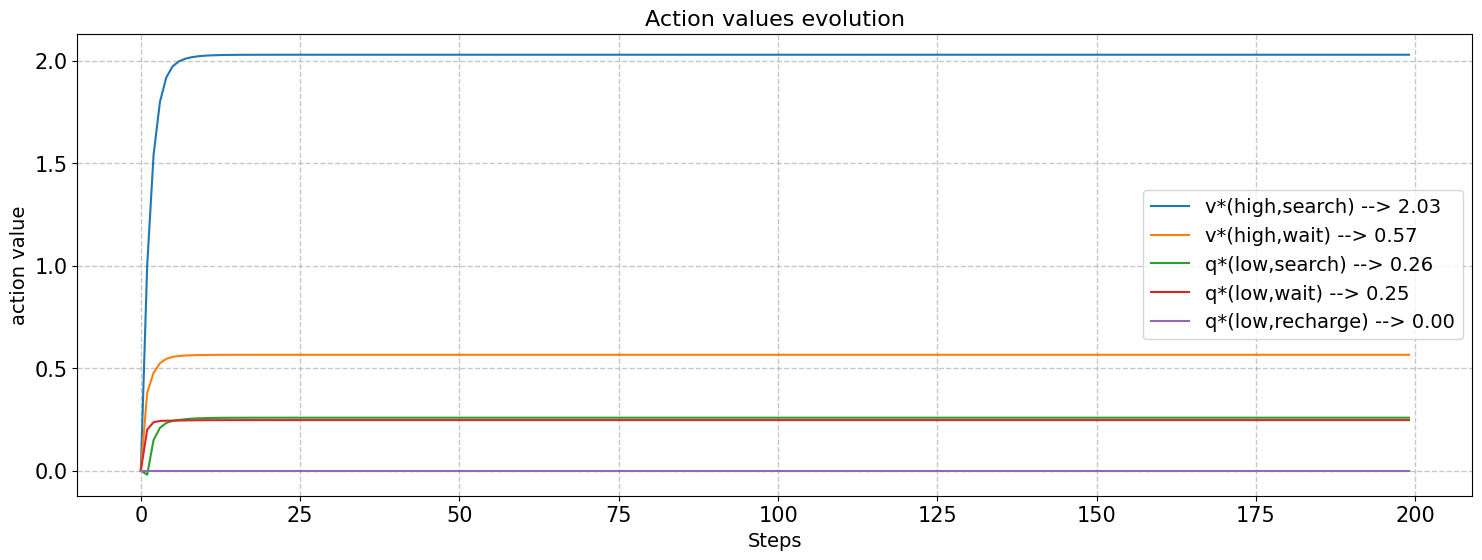

In [165]:
steps = 200
high_search_actionValueVector = np.zeros(steps)
high_wait_actionValueVector = np.zeros(steps)
low_search_actionValueVector = np.zeros(steps)
low_wait_actionValueVector = np.zeros(steps)
low_recharge_actionValueVector = np.zeros(steps)

for i in range(steps):
    high_search_actionValueVector[i] =  robot.actionValues["high"]["search"]
    high_wait_actionValueVector[i] = robot.actionValues["high"]["wait"]
    low_search_actionValueVector[i] =  robot.actionValues["low"]["search"]
    low_wait_actionValueVector[i] = robot.actionValues["low"]["wait"]
    low_recharge_actionValueVector[i] = robot.actionValues["low"]["recharge"]
    robot.updateActionValues()

fig, ax = plt.subplots(figsize=(18,6))
plt.plot(range(steps),high_search_actionValueVector,label=f"v*(high,search) --> {high_search_actionValueVector[i]:.2f}")
plt.plot(range(steps),high_wait_actionValueVector,label=f"v*(high,wait) --> {high_wait_actionValueVector[i]:.2f}")
plt.plot(range(steps),low_search_actionValueVector,label=f"q*(low,search) --> {low_search_actionValueVector[i]:.2f}")
plt.plot(range(steps),low_wait_actionValueVector,label=f"q*(low,wait) --> {low_wait_actionValueVector[i]:.2f}")
plt.plot(range(steps),low_recharge_actionValueVector,label=f"q*(low,recharge) --> {low_recharge_actionValueVector[i]:.2f}")

ax.set_title('Action values evolution', fontsize=16)
plt.legend(fontsize = 14)
ax.set_ylabel('action value', fontsize=14)
ax.set_xlabel('Steps', fontsize=14)
ax.grid(True, which='both', linestyle='--', linewidth=1, alpha=0.7)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)